In [1]:
import sys, argparse, os, multiprocessing.pool
from tqdm import tqdm

import pandas as pd
import numpy as np
import torch, librosa
import torch.nn as nn
import ffmpeg, torchaudio
from ffmpeg import Error

/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [2]:
source_media = '/mediazen/2022/2/raw/ok_takes/20220727_hynew100_0/hynew100_0_mediazen.mov'
target_audio = '/root/mediazen/s2b/notebook/sample.wav'

## Video(.mov) -> Audio(.wav)

In [3]:
try:
    (ffmpeg
        .input(source_media, vn=None)
        .output(filename=target_audio,
                ac=1, # number of audio channels 
                acodec='pcm_s16le', # audio codec (PCM signed 16-bit little-endian)
                ar='16k', # audio sampling frequency
                loglevel='error', # logging level e.g., 'repeat' / 'level' / 'quite' / 'error' ...
                nostats=None
                )
        .run(overwrite_output=True)
        )
except Error as err:
    print(f'ffmpeg on {source_media} failed')
    raise

## Audio(.wav) -> Power Spectrogram

In [4]:
HERTZ = 50
audio_tensor, sample_rate = torchaudio.load(target_audio)
squeezed_audio_tensor = audio_tensor.squeeze()
squeezed_audio_ndarray = squeezed_audio_tensor.numpy()

n_fft = int(sample_rate / HERTZ)
hop_length = int(sample_rate / (HERTZ * 2))
D = librosa.stft(
    squeezed_audio_ndarray, 
    n_fft=n_fft, 
    win_length=n_fft, 
    hop_length=hop_length, 
    window='hamming')
spectrogram, phase = librosa.magphase(D)

# S = log(S+1)
log_spectrogram = np.log1p(spectrogram)
mean, stdev = log_spectrogram.mean(), log_spectrogram.std()
normalized_spectrogram = (log_spectrogram - mean) / stdev
normalized_spectrogram_tensor = torch.FloatTensor(normalized_spectrogram)

In [5]:
squeezed_audio_ndarray.shape[0] / sample_rate

49.132

In [6]:
D.shape, spectrogram.shape, phase.shape

((161, 4914), (161, 4914), (161, 4914))

In [7]:
D[0], spectrogram[0], phase[0]

(array([-0.01582523+0.j, -0.03261247+0.j,  0.00801908+0.j, ...,
        -0.06130207+0.j, -0.00054157+0.j,  0.00016798+0.j], dtype=complex64),
 array([0.01582523, 0.03261247, 0.00801908, ..., 0.06130207, 0.00054157,
        0.00016798], dtype=float32),
 array([-1.-8.742278e-08j, -1.-8.742278e-08j,  1.+0.000000e+00j, ...,
        -1.-8.742278e-08j, -1.-8.742278e-08j,  1.+0.000000e+00j],
       dtype=complex64))

In [8]:
# n_fft = int(self.sample_rate * self.window_size)
# win_length = n_fft
# hop_length = int(self.sample_rate * self.window_stride)

n_fft = int(16000 * 0.02)
win_length = n_fft
hop_length = int(16000 * 0.01)
n_fft, hop_length

(320, 160)

## Sample Data

In [5]:
import math

import sys
sys.path.append('/root/mediazen/s2b')

from src.dataset import FaceDataset
from src.deepspeech import Jangnan
from src.utils import plot_spectrogram, plot_result

In [4]:
# dataset

data_dir = '/root/mediazen/speech2anim/essentials_1443'
essentials_dir = [d.path for d in os.scandir(data_dir)]
audio_path, shape_path = essentials_dir
audio_path, shape_path

audio_pt = torch.load(audio_path)
shape_pt = torch.load(shape_path)

ds = FaceDataset(audio_pt[2], audio_pt[3], shape_pt[3], shape_pt[4], (audio_pt[1], shape_pt[0]))

In [5]:
sample_data = ds[1288]
spec, spec_len, blendshape, blendshape_len, idx, timecode = sample_data
spec.shape, spec_len, blendshape.shape, blendshape_len

(torch.Size([11682, 161]),
 tensor(4914, dtype=torch.int32),
 torch.Size([7012, 16]),
 tensor(2952, dtype=torch.int32))

In [6]:
spec = spec.unsqueeze(0)
spec_len = spec_len.unsqueeze(0)
blendshape = blendshape.unsqueeze(0)
blendshape_len = blendshape_len.unsqueeze(0)

## Power Spectrogram -> DeepSpeech

In [6]:
encoder = Jangnan()
encoder.load_state_dict(torch.load('/root/mediazen/s2b/pretrained/jangnan.pt'))

<All keys matched successfully>

In [8]:
encoder

Jangnan(
  (conv): MaskConv(
    (seq_module): Sequential(
      (0): Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Hardtanh(min_val=0, max_val=20, inplace=True)
      (3): Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Hardtanh(min_val=0, max_val=20, inplace=True)
    )
  )
  (rnns): Sequential(
    (0): BatchRNN(
      (rnn): LSTM(1312, 1024, bidirectional=True)
    )
    (1): BatchRNN(
      (batch_norm): SequenceWise (
      BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
      (rnn): LSTM(1024, 1024, bidirectional=True)
    )
    (2): BatchRNN(
      (batch_norm): SequenceWise (
      BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
      (rnn): LSTM(1024, 1024, bidirec

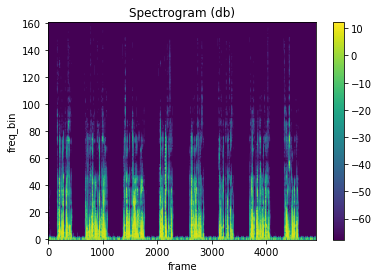

In [9]:
plot_spectrogram(spec[0][:spec_len[0]].T)

In [10]:
enc_out = encoder(spec, spec_len)
enc_out.shape

torch.Size([5841, 1, 1024])

In [41]:
from deepspeech import *

In [46]:
conv1 = MaskConv(nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5)),
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, 20, inplace=True)
        ))

conv2 = MaskConv(nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5)),
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, 20, inplace=True)
        ))

def get_seq_lens(conv, input_length):
    """
    Given a 1D Tensor or Variable containing integer sequence lengths, return a 1D tensor or variable
    containing the size sequences that will be output by the network.
    :param input_length: 1D Tensor
    :return: 1D Tensor scaled by model
    """
    seq_len = input_length
    for m in conv.modules():
        if type(m) == nn.modules.conv.Conv2d:
            seq_len = ((seq_len + 2 * m.padding[1] - m.dilation[1] * (m.kernel_size[1] - 1) - 1) // m.stride[1] + 1)
    return seq_len.int()

In [47]:
x, lengths = spec.unsqueeze(0), get_seq_lens(conv1, spec_len.unsqueeze(0).cpu().int())
lengths = lengths.cpu().int()
x = x.unsqueeze(1) # 1, 1, 11682, 161
x = x.permute(0, 1, 3, 2) # 1, 1, 161, 11682

In [51]:
lengths

tensor([2457], dtype=torch.int32)

In [52]:
conv1_out, lengths = conv1(x, lengths)
conv1_out.shape

torch.Size([1, 32, 81, 5841])

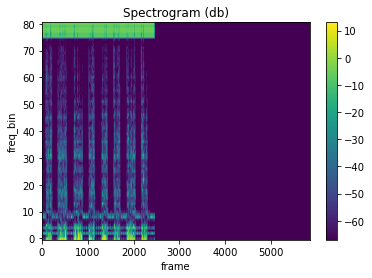

In [59]:
plot_spectrogram(conv1_out[0][0].view(-1, 5841).detach())

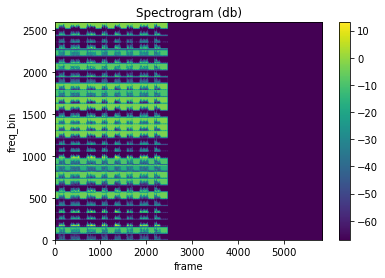

In [54]:
plot_spectrogram(conv1_out[0].view(-1, 5841).detach())

In [53]:
conv2_out, _ = conv2(conv1_out, lengths)
conv2_out.shape

torch.Size([1, 32, 41, 5841])

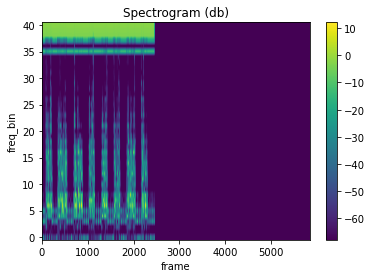

In [60]:
plot_spectrogram(conv2_out[0][0].view(-1, 5841).detach())

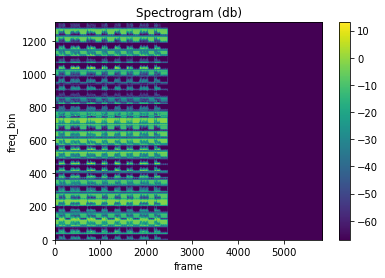

In [55]:
plot_spectrogram(conv2_out[0].view(-1, 5841).detach())

In [69]:
# Subtitute variables
sample_rate = 16000
window_size = .02
hidden_size = 1024
rnn_type = nn.LSTM
hidden_layers = 5

# Based on above convolutions and spectrogram size using conv formula (W - F + 2P)/ S+1
rnn_input_size = int(math.floor((sample_rate * window_size) / 2) + 1) # 161
rnn_input_size = int(math.floor(rnn_input_size + 2 * 20 - 41) / 2 + 1) # 81
rnn_input_size = int(math.floor(rnn_input_size + 2 * 10 - 21) / 2 + 1) # 41
rnn_input_size *= 32 # 1312 (32: num of channels)

rnns = nn.Sequential(
            BatchRNN(
                input_size=rnn_input_size,
                hidden_size=hidden_size,
                rnn_type=rnn_type,
                bidirectional=True,
                batch_norm=False
            ),
            *(
                BatchRNN(
                    input_size=hidden_size,
                    hidden_size=hidden_size,
                    rnn_type=rnn_type,
                    bidirectional=True
                ) for x in range(hidden_layers - 1)
            )
        )

torch.Size([5841, 1, 1024])


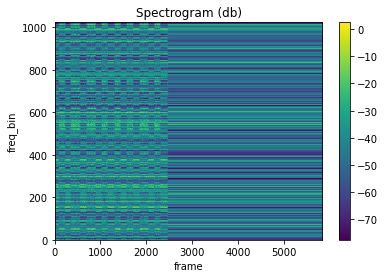

torch.Size([5841, 1, 1024])


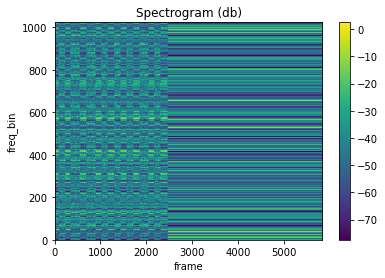

torch.Size([5841, 1, 1024])


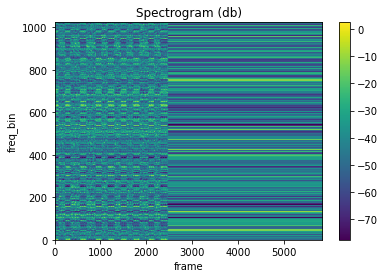

torch.Size([5841, 1, 1024])


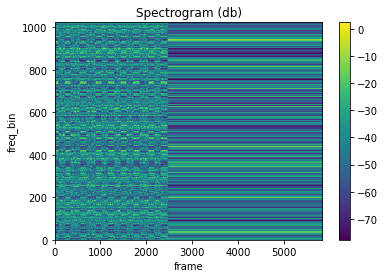

torch.Size([5841, 1, 1024])


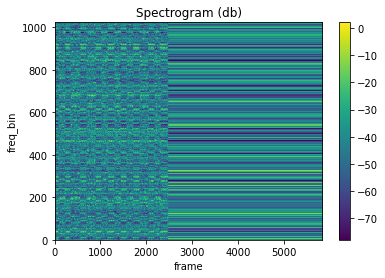

In [71]:
sizes = conv2_out.size()
conv2_out = conv2_out.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # Collapse feature dimension
rnn_out = conv2_out.permute(2,0,1)  # TxNxH

for rnn in rnns:
    rnn_out = rnn(rnn_out, lengths)
    print(rnn_out.shape)
    plot_spectrogram(rnn_out.squeeze().T.detach())

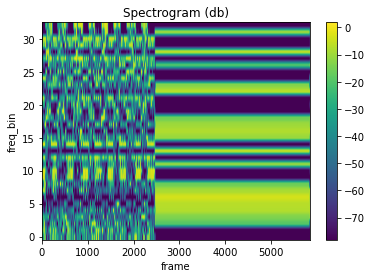

In [105]:
plot_spectrogram(rnn_out.squeeze().T[:33].detach())

In [75]:
encoder_out = rnn_out.permute(1, 0, 2).contiguous()
encoder_out.shape

torch.Size([1, 5841, 1024])

## Deepspeech -> Interpolate

In [20]:
def interpolate_features(features, input_rate, output_rate, output_len=None):
    batch_size = features.shape[0]
    num_features = features.shape[2] # 1024
    input_len = features.shape[1] # 5841
    seq_len = input_len / float(input_rate) # 116.82
    if output_len is None:
        output_len = int(seq_len * output_rate)
    input_timestamps = np.arange(input_len) / float(input_rate)
    output_timestamps = np.arange(output_len) / float(output_rate)
    output_features = np.zeros((batch_size, output_len, num_features))
    features_numpy = features.cpu().data.numpy()
    for batch in range(batch_size):
        for feat in range(num_features):
            output_features[batch][:, feat] = np.interp(output_timestamps,
                                                input_timestamps,
                                                features_numpy[batch][:, feat])
    return torch.from_numpy(output_features).float()
    
interpolate_out = interpolate_features(
    enc_out.permute(1, 0, 2).contiguous(), # 1 * 5841 * 1024
    50, 
    60, 
    output_len=len(blendshape[0])) # 7012
interpolate_out.shape

torch.Size([1, 7012, 1024])

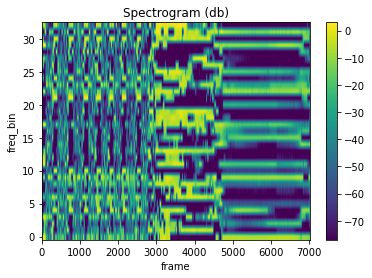

In [12]:
plot_spectrogram(interpolate_out[0].T[:33].detach())

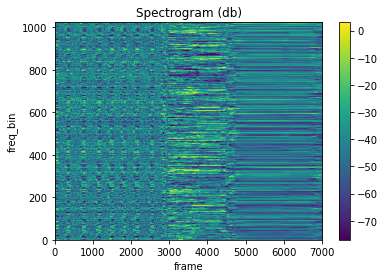

In [32]:
plot_spectrogram(interpolate_out[0].T.detach())

In [33]:
1/0.033

30.3030303030303

In [34]:
4914 / 2 * 6 / 5

2948.4

In [35]:
blendshape_len

tensor([2952], dtype=torch.int32)

In [36]:
49.132 * 60

2947.92

## Interpolate -> FC Layer

In [124]:
fully_connected = nn.Sequential(
            nn.AdaptiveAvgPool1d(1024),
            nn.Linear(1024, 1024, bias=False),
            nn.ReLU6(),
            nn.Dropout(0.2),
            nn.Linear(1024, 16, bias=False),
        )

In [125]:
fc_out = fully_connected(interpolate_out)
fc_out.shape

torch.Size([1, 7012, 16])

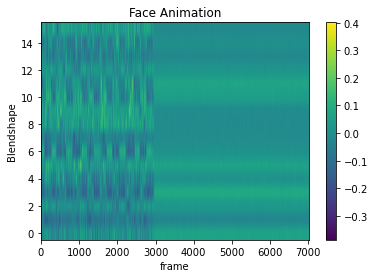

In [173]:
plot_result(fc_out[0].T.detach())

In [129]:
fc_out[0][0]

tensor([ 0.1640, -0.0776,  0.0252, -0.0706, -0.1115,  0.0535, -0.0982, -0.1305,
        -0.0546,  0.0077,  0.0180, -0.0451,  0.0465,  0.0080,  0.0504,  0.0999],
       grad_fn=<SelectBackward>)

In [127]:
class ClipModule(nn.Module):
    def __init__(self, min_threshold, max_threshold):
        super(ClipModule, self).__init__()
        self.min_threshold = min_threshold
        self.max_threshold = max_threshold

    
    def forward(self, x):
        return torch.clamp(x, min=self.min_threshold, max=self.max_threshold)

clip = ClipModule(min_threshold=0, max_threshold=1)

out = clip(fc_out)
out.shape

torch.Size([1, 7012, 16])

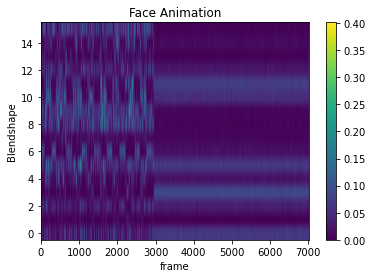

In [172]:
plot_result(out[0].T.detach())

In [130]:
out[0][0]

tensor([0.1640, 0.0000, 0.0252, 0.0000, 0.0000, 0.0535, 0.0000, 0.0000, 0.0000,
        0.0077, 0.0180, 0.0000, 0.0465, 0.0080, 0.0504, 0.0999],
       grad_fn=<SelectBackward>)

In [161]:
ones_list = torch.ones(blendshape_len[0].item(), 16)
length_mask = torch.nn.utils.rnn.pad_sequence(ones_list, batch_first=True)

In [162]:
length_mask.shape

torch.Size([2952, 16])

In [167]:
chopped_out = out[:, :max(blendshape_len), :]
chopped_y = blendshape[:, :max(blendshape_len), :]
masked_out = chopped_out * length_mask

In [164]:
masked_out.shape

torch.Size([1, 2952, 16])

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
%cd /root/mediazen/s2b/
from src.model import GGomYangModel
model = GGomYangModel.load_from_checkpoint('/root/mediazen/speech2anim/ckpt2/epoch=6-step=7055.ckpt')

/root/mediazen/s2b


In [ ]:
class SequenceWise(nn.Module):
    def __init__(self, module):
        """
        Collapses input of dim T*N*H to (T*N)*H, and applies to a module.
        Allows handling of variable sequence lengths and minibatch sizes.
        :param module: Module to apply input to.
        """
        super(SequenceWise, self).__init__()
        self.module = module

    def forward(self, x):
        t, n = x.size(0), x.size(1)
        x = x.view(t * n, -1)
        x = self.module(x)
        x = x.view(t, n, -1)
        return x

    def __repr__(self):
        tmpstr = self.__class__.__name__ + ' (\n'
        tmpstr += self.module.__repr__()
        tmpstr += ')'
        return tmpstr

class BatchRNN(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_type=nn.LSTM, bidirectional=False, batch_norm=True):
        super(BatchRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.batch_norm = SequenceWise(nn.BatchNorm1d(input_size)) if batch_norm else None
        self.rnn = rnn_type(input_size=input_size, hidden_size=hidden_size,
                            bidirectional=bidirectional, bias=True)
        self.num_directions = 2 if bidirectional else 1

    def flatten_parameters(self):
        self.rnn.flatten_parameters()

    def forward(self, x, lengths):
        if self.batch_norm is not None:
            x = self.batch_norm(x)
        # x = nn.utils.rnn.pack_padded_sequence(x, lengths, enforce_sorted=False)
        x, h = self.rnn(x)
        # x, _ = nn.utils.rnn.pad_packed_sequence(x)
        if self.bidirectional:
            x = x.view(x.size(0), x.size(1), 2, -1).sum(2).view(x.size(0), x.size(1), -1)  # (TxNxH*2) -> (TxNxH) by sum
        return x

# Subtitute variables
sample_rate = 16000
window_size = .02
hidden_size = 1024
rnn_type = nn.LSTM
hidden_layers = 5

# Based on above convolutions and spectrogram size using conv formula (W - F + 2P)/ S+1
rnn_input_size = int(math.floor((sample_rate * window_size) / 2) + 1)
rnn_input_size = int(math.floor(rnn_input_size + 2 * 20 - 41) / 2 + 1)
rnn_input_size = int(math.floor(rnn_input_size + 2 * 10 - 21) / 2 + 1)
rnn_input_size *= 32

rnns = nn.Sequential(
            BatchRNN(
                input_size=rnn_input_size,
                hidden_size=hidden_size,
                rnn_type=rnn_type,
                bidirectional=True,
                batch_norm=False
            ),
            *(
                BatchRNN(
                    input_size=hidden_size,
                    hidden_size=hidden_size,
                    rnn_type=rnn_type,
                    bidirectional=True
                ) for x in range(hidden_layers - 1)
            )
        )

In [14]:
model.fc

Sequential(
  (0): Sequential(
    (0): AdaptiveAvgPool1d(output_size=1024)
    (1): Linear(in_features=1024, out_features=1024, bias=False)
    (2): ReLU6()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=16, bias=False)
  )
  (1): ClipModule()
)

In [15]:
spec.shape, spec_len, blendshape.shape, blendshape_len.shape

(torch.Size([1, 11682, 161]),
 tensor([4914], dtype=torch.int32),
 torch.Size([1, 7012, 16]),
 torch.Size([1]))

In [16]:
out = model(spec, spec_len, blendshape, blendshape_len)
out.shape

torch.Size([1, 7012, 16])

In [17]:
ones_list = [torch.ones(length, 16) for length in blendshape_len]
length_mask = torch.nn.utils.rnn.pad_sequence(ones_list, batch_first=True)

chopped_out = out[:, :max(blendshape_len), :]
chopped_y = blendshape[:, :max(blendshape_len), :]
masked_out = chopped_out * length_mask
masked_out.shape

torch.Size([1, 2952, 16])

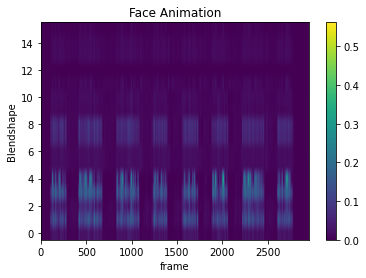

In [54]:
plot_result(masked_out[0].T.detach())

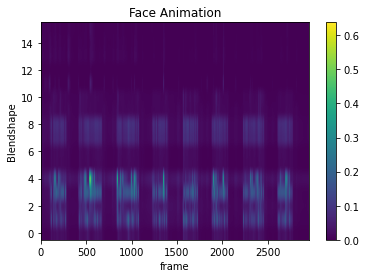

In [55]:
plot_result(chopped_y[0].T.detach())

## Discriminator

In [45]:
interpolate_out.shape

torch.Size([1, 7012, 1024])

In [46]:
ones_list = [torch.ones(length, 1024) for length in blendshape_len]
length_mask = torch.nn.utils.rnn.pad_sequence(ones_list, batch_first=True)

chopped_interpolate_out = interpolate_out[:, :max(blendshape_len), :]
masked_interpolate_out = chopped_interpolate_out * length_mask
masked_interpolate_out.shape

torch.Size([1, 2952, 1024])

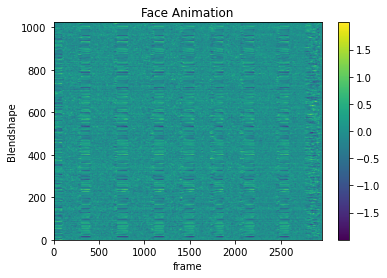

In [22]:
plot_result(masked_interpolate_out[0].T.detach())

In [34]:
class Dis_block(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
    
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x

In [38]:
masked_interpolate_out.shape, masked_out.shape, chopped_y.shape

(torch.Size([1, 2952, 1024]),
 torch.Size([1, 2952, 16]),
 torch.Size([1, 2952, 16]))

In [48]:
B, T, C = masked_interpolate_out.shape
F = masked_out.shape[-1]
masked_interpolate_out = masked_interpolate_out.view((B, T, int(C/F), F)).permute(0, 2, 1, 3)
masked_interpolate_out.shape

torch.Size([1, 64, 2952, 16])

In [51]:
masked_out = masked_out.unsqueeze(1)
chopped_y = chopped_y.unsqueeze(1)
masked_out.shape, chopped_y.shape

(torch.Size([1, 1, 2952, 16]), torch.Size([1, 1, 2952, 16]))

In [52]:
fake = torch.cat((masked_interpolate_out, masked_out), 1)
real = torch.cat((masked_interpolate_out, chopped_y), 1)

fake.shape, real.shape

(torch.Size([1, 65, 2952, 16]), torch.Size([1, 65, 2952, 16]))

In [53]:
fake_1 = Dis_block(65, 64, False)(fake)
fake_1.shape

torch.Size([1, 64, 1476, 8])

In [54]:
fake_4 = nn.Sequential(
    Dis_block(64,128),
    Dis_block(128,256),
    Dis_block(256,512))(fake_1)
fake_4.shape

torch.Size([1, 512, 185, 1])

In [55]:
fake_patch = nn.Conv2d(512,1,3,padding=1)(fake_4)
fake_patch = torch.sigmoid(fake_patch)
fake_patch.shape

torch.Size([1, 1, 185, 1])

In [ ]:
def compare_models(model_1, model_2):
    models_differ = 0
    for key_item_1, key_item_2 in zip(model_1.state_dict().items(), model_2.state_dict().items()):
        if torch.equal(key_item_1[1], key_item_2[1]):
            pass
        else:
            models_differ += 1
            if (key_item_1[0] == key_item_2[0]):
                print('Mismtach found at', key_item_1[0])
            else:
                raise Exception
    if models_differ == 0:
        print('Models match perfectly! :)')

In [ ]:
base_model = GGomYangModel(0.001, 1024, 1024, 16)

In [ ]:
compare_models(encoder, base_model.jangnan_encoder)

Models match perfectly! :)


In [ ]:
compare_models(encoder, model.jangnan_encoder)

Mismtach found at conv.seq_module.1.running_mean
Mismtach found at conv.seq_module.1.running_var
Mismtach found at conv.seq_module.1.num_batches_tracked
Mismtach found at conv.seq_module.4.running_mean
Mismtach found at conv.seq_module.4.running_var
Mismtach found at conv.seq_module.4.num_batches_tracked
Mismtach found at rnns.1.batch_norm.module.running_mean
Mismtach found at rnns.1.batch_norm.module.running_var
Mismtach found at rnns.1.batch_norm.module.num_batches_tracked
Mismtach found at rnns.2.batch_norm.module.running_mean
Mismtach found at rnns.2.batch_norm.module.running_var
Mismtach found at rnns.2.batch_norm.module.num_batches_tracked
Mismtach found at rnns.3.batch_norm.module.running_mean
Mismtach found at rnns.3.batch_norm.module.running_var
Mismtach found at rnns.3.batch_norm.module.num_batches_tracked
Mismtach found at rnns.4.batch_norm.module.running_mean
Mismtach found at rnns.4.batch_norm.module.running_var
Mismtach found at rnns.4.batch_norm.module.num_batches_tracke